https://github.com/Delve-ERAV1/Phi-2-Vision-Language

In [1]:
  # !pip install -U -q transformers accelerate bitsandbytes
  # !pip install -q pillow
  # !pip install -q lightning

In [2]:
# !git clone https://huggingface.co/datasets/BUAADreamer/pokemon-gpt4-1k/

In [3]:
import json
import pandas as pd

import glob2
import torch
import lightning.pytorch as pl
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import random_split, DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import LearningRateMonitor

import numpy as np
from PIL import Image
import io

import torch.nn as nn
from torch.nn import functional as F
from lightning.pytorch import LightningModule
from transformers import AutoModelForCausalLM, CLIPVisionModel, AutoTokenizer

In [4]:
# Parquet 파일 읽기
df = pd.read_parquet('/content/pokemon-gpt4-1k/data/train-00000-of-00001.parquet')

In [5]:
# torch.multiprocessing.set_start_method('spawn')

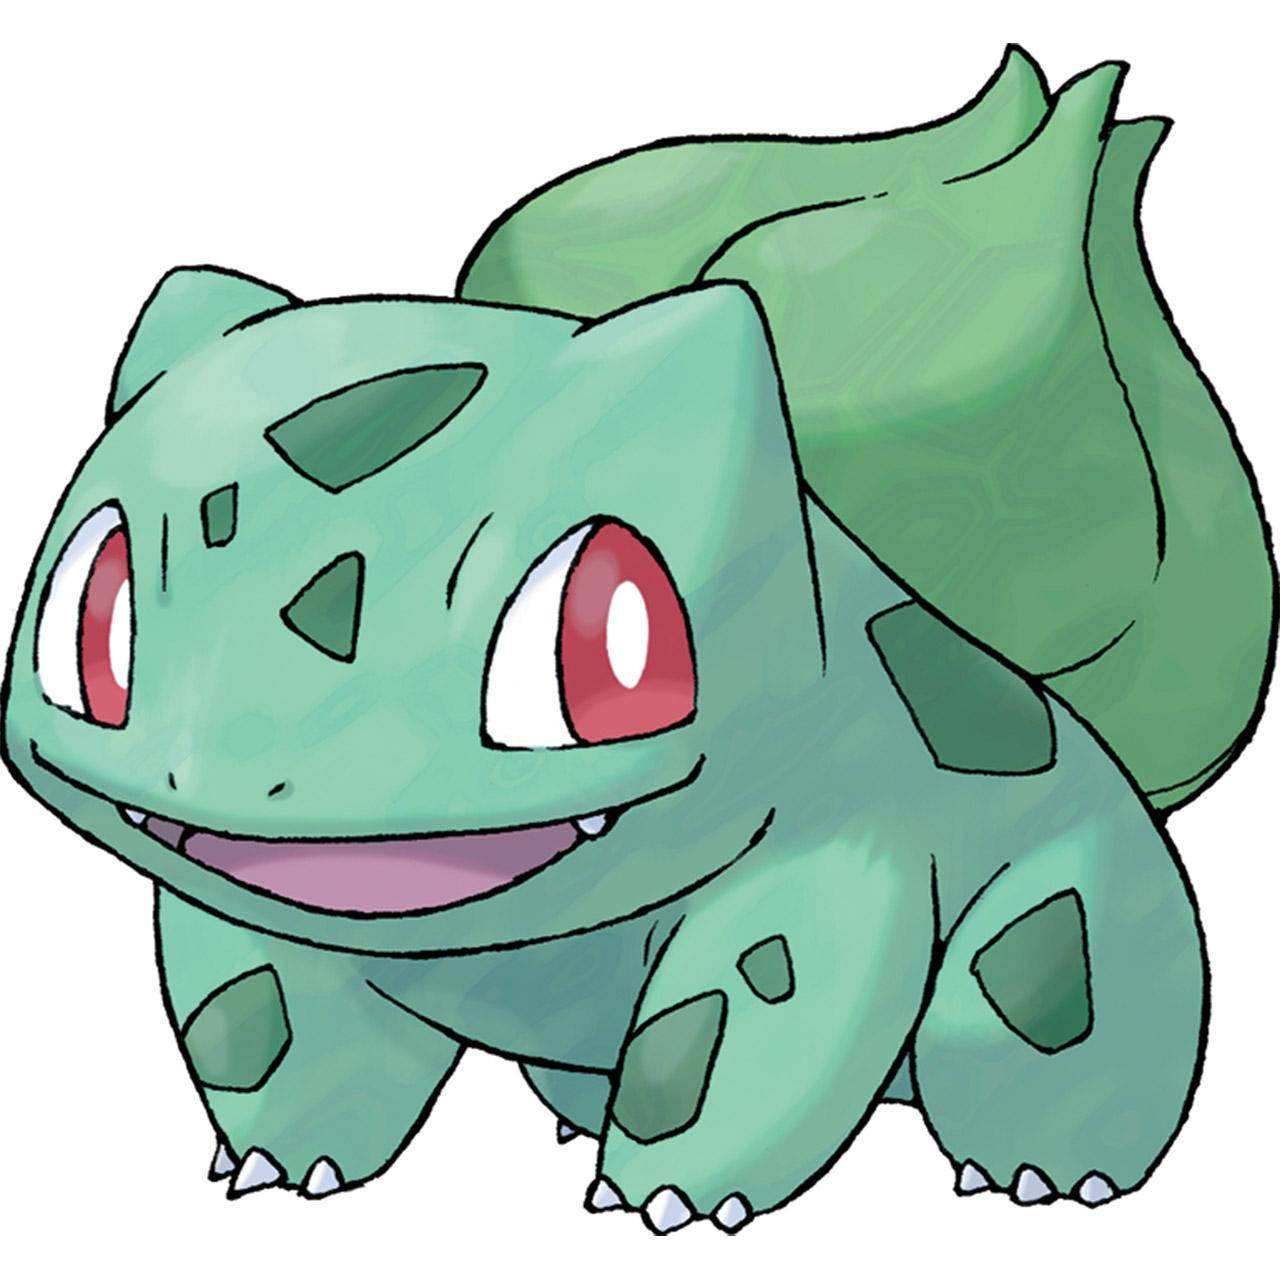

In [6]:
image_bytes = df['images'][0][0]['bytes']
image = Image.open(io.BytesIO(image_bytes))

# 이미지 표시
image

In [7]:
df.head()

,messages,images
0,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
1,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
2,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
3,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
4,"[{'role': 'user', 'content': 'Provide caption ...",[{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...


In [8]:
print(df['messages'][0][0])
print(df['messages'][0][1])

{'role': 'user', 'content': 'Provide caption for the image in one sentence. Be detailed but precise.'}
{'role': 'assistant', 'content': 'A cheerful Bulbasaur ready for its next Pokémon adventure.'}


In [9]:
torch.set_default_device("cuda")

In [10]:
clip_model_name = "openai/clip-vit-base-patch32"
phi_model_name = "microsoft/phi-2"

# CLIPQuestionAnsweringModel은 LightningModule을 상속하며, 멀티모달 질문 응답 모델을 구현

class CLIPQuestionAnsweringModel(LightningModule):
    def __init__(self, clip_embed=768, phi_embed=2560):
        super().__init__()
        self.EOS_TOKEN_ID = 50256
        self.QUESTION_ANSWER_SEPARATOR_ID = 50295  # 질문과 답변을 구분하는 특수 토큰 ID
        self.IMAGE_SEPARATOR_TOKENS = [685, 36259, 14041, 60, 220]
        self.tokenizer = tokenizer

        # 사전 학습된 언어 모델을 로드
        self.clip_model = CLIPVisionModel.from_pretrained(clip_model_name)
        self.projection =Projections(clip_embed, phi_embed)
        self.text_model = AutoModelForCausalLM.from_pretrained(phi_model_name,
                                                               torch_dtype=torch.float16,
                                                               device_map="cuda",
                                                               trust_remote_code=True)
        self.text_model.config.use_cache = False

        # Freeze Weights
        for network in [self.text_model, self.clip_model]:
            for param in network.parameters():
                param.requires_grad_(False)


    # 모델의 forward 메서드
    def forward(self, images, input_ids):
        images = {"pixel_values": images}
        clip_outputs = self.clip_model(**images)
        images = clip_outputs.last_hidden_state[:, 1:, :]

        # 입력 임베딩 계산
        input_embeddings = self.text_model.model.embed_tokens(input_ids)
        projected_image_embeds = self.projection(images).to(torch.float16)

        # 이미지 임베딩과 텍스트 임베딩을 결합
        combined_embeddings = torch.cat((projected_image_embeds, input_embeddings), dim=1)

        # 모델 예측
        outputs = self.text_model(inputs_embeds=combined_embeddings).logits
        del combined_embeddings, input_embeddings

        return outputs

    def training_step(self, batch, batch_idx):
        images, input_ids, target_ids = batch
        self.print_predictions(batch, self.global_step)

        # target_ids가 텐서 형태인지 확인
        if isinstance(target_ids, tuple):
            target_ids = torch.stack(target_ids)

        outputs = self.forward(images, input_ids)

        # 질문-답변 구분자 인덱스 찾기
        separator_indices = (input_ids == self.QUESTION_ANSWER_SEPARATOR_ID).nonzero(as_tuple=True)[1]
        answer_start_indices = separator_indices + 1

        collected_logits = []
        collected_targets = []

        # 출력 로그와 타겟 수집
        for i in range(input_ids.size(0)):
            if answer_start_indices[i].item() < outputs.size(1):
                logits = outputs[i, answer_start_indices[i].item():, :]
                target = target_ids[i, answer_start_indices[i].item():]

                max_len = max(logits.size(0), target.size(0))

                if logits.size(0) < max_len:
                    pad_size = max_len - logits.size(0)
                    logits = F.pad(logits, (0, 0, 0, pad_size), value=self.EOS_TOKEN_ID)

                if target.size(0) < max_len:
                    pad_size = max_len - target.size(0)
                    target = F.pad(target, (0, pad_size), value=self.EOS_TOKEN_ID)

                collected_logits.append(logits)
                collected_targets.append(target)

        # 텐서로 변환 및 크기 맞추기
        answer_logits_flat = torch.cat(collected_logits, dim=0)
        target_sequences_flat = torch.cat(collected_targets, dim=0)


        # # 출력 로그와 타겟 수집
        # for i in range(input_ids.size(0)):
        #     if answer_start_indices[i] + 49 < outputs.size(1):
        #         collected_logits.append(outputs[i, answer_start_indices[i] + 49, :])
        #         collected_targets.append(target_ids[i])
        #     elif answer_start_indices[i] < outputs.size(1):
        #         collected_logits.append(outputs[i, -1, :])
        #         collected_targets.append(target_ids[i])

        # answer_logits_flat = torch.cat(collected_logits).reshape(-1, outputs.size(-1))
        # target_sequences_flat = torch.cat(collected_targets)

        # 손실 계산
        loss = F.cross_entropy(answer_logits_flat, target_sequences_flat, ignore_index=self.EOS_TOKEN_ID)

        # 손실 로그 기록
        self.log("loss", loss, prog_bar=True, on_step=True, logger=True)

        del outputs, answer_logits_flat, collected_logits
        return loss


    # 옵티마이저와 스케줄러 설정
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-8)
        scheduler = OneCycleLR(
            optimizer,
            max_lr=1e-5,
            pct_start=0.01,
            total_steps=self.trainer.max_steps,
            anneal_strategy='cos',
            div_factor=100,
            final_div_factor=1000,
        )
        return {'optimizer': optimizer,
                'lr_scheduler': {'scheduler': scheduler, 'interval': 'step'}}

    # 예측 출력
    def print_predictions(self, batch, global_step):
        if global_step % 100 == 0:  # 매 100 스텝마다 출력
            images, input_ids, target_ids = batch
            num_examples = 4

            outputs = self.forward(images, input_ids)
            predicted_token_ids = outputs.argmax(dim=-1)[:num_examples]

            separator_indices = (input_ids == self.QUESTION_ANSWER_SEPARATOR_ID).nonzero(as_tuple=True)[1][:num_examples]
            image_separator_indices = (input_ids == self.IMAGE_SEPARATOR_TOKENS[0]).nonzero(as_tuple=True)[1][:num_examples]

            predicted_answers = [self.tokenizer.decode(ids[(sep_index + 49):].tolist(), skip_special_tokens=True) for ids, sep_index in zip(predicted_token_ids, separator_indices)]
            actual_answers = [self.tokenizer.decode(ids[(sep_index + 1):].tolist(), skip_special_tokens=True) for ids, sep_index in zip(input_ids[:num_examples], separator_indices)]

            print(f"Predicted Answer: {predicted_answers}")
            print(f"Actual Answer: {actual_answers}")
            print("------------")

    # 체크포인트 저장 시 호출
    def on_save_checkpoint(self, checkpoint):

        keys = checkpoint['state_dict'].keys()
        keys = [k for k in keys if 'projection' not in k]

        for k in keys:
            del checkpoint['state_dict'][k]


# Projections 클래스는 이미지 임베딩을 처리
class Projections(nn.Module):
    def __init__(
        self,
        clip_embed,
        phi_embed,
        num_projection_layers=6,
    ):
        super().__init__()

        self.norm = nn.LayerNorm(phi_embed)
        self.output = nn.Linear(clip_embed, phi_embed)
        self.projection_layers = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(phi_embed, phi_embed),
                    nn.GELU(),
                    nn.Linear(phi_embed, phi_embed),
                )
                for _ in range(num_projection_layers)
            ]
        )

    def forward(self, x):
        x = self.output(x)
        self.norm(x)
        for layer in self.projection_layers:
            residual = x
            x = layer(x) + residual

        return x


# 프로젝션 모델을 체크포인트에서 로드
def load_projection_model(path, clip_embed, phi_embed):
    """Loads a Projections model instance from a checkpoint and returns it with weights loaded.

    Args:
        path (str): Path to the checkpoint file.

    Returns:
        torch.nn.Module: The loaded Projections model instance.
    """

    state_dict = torch.load(path)['state_dict']
    new_state_dict = {k.replace('projection.', ''): v for k, v in state_dict.items()}

    model = Projections(clip_embed, phi_embed)
    model.load_state_dict(new_state_dict)

    return model

In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import json
import torch
from PIL import Image
from torch.utils.data import Dataset
from lightning.pytorch import LightningDataModule
from transformers import AutoProcessor, AutoTokenizer
from torch.utils.data import random_split, DataLoader


tokenizer  = AutoTokenizer.from_pretrained(phi_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_tokens('<question-answer>')


class ImageCaptionDataset(Dataset):
    def __init__(self, df, phi_model_name, clip_model_name):

        self.tokenizer  = AutoTokenizer.from_pretrained(phi_model_name, trust_remote_code=True)
        self.processor  = AutoProcessor.from_pretrained(clip_model_name)
        self.tokenizer.add_tokens('<question-answer>')
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        df = self.data.iloc[idx]
        image_bytes = df['images'][0]['bytes']
        img = Image.open(io.BytesIO(image_bytes))
        image_processed = self.processor(images=img, return_tensors="pt")['pixel_values']
        image_processed = image_processed.squeeze(0)

        input_ids  = self.tokenizer(f"Instruct: {df['messages'][0]['content']}<question-answer>\n\nOutput: {df['messages'][1]['content']}<|endoftext|>", return_tensors="pt", return_attention_mask=False)
        target_ids = self.tokenizer(f"Instruct: {df['messages'][0]['content']}<question-answer>\n\nOutput: {df['messages'][1]['content']}<|endoftext|>", return_tensors="pt", return_attention_mask=False)

        return(image_processed, input_ids['input_ids'].squeeze(0).cuda(), target_ids['input_ids'].squeeze(0).cuda())

def collate_fn(batch):
    image_names, input_ids, target_ids = zip(*batch)
    images = torch.stack(image_names, dim=0)

    captions_padded = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.eos_token_id)

    input_ids_padded = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(ids) for ids in input_ids],
         batch_first=True,
         padding_value=tokenizer.eos_token_id
    )

    target_ids_padded = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(ids) for ids in target_ids],
         batch_first=True,
         padding_value=tokenizer.eos_token_id
    )

    return images, input_ids_padded, target_ids_padded

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
batch_size = 1
num_workers = 0

train_dataset = ImageCaptionDataset(df, phi_model_name, clip_model_name)

train_dataloader = DataLoader(train_dataset,
                              collate_fn=collate_fn, batch_size=batch_size,
                              shuffle=True, pin_memory=False, generator=torch.Generator(device="cuda"))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
train_dataset[0][1]

tensor([43993,    25, 44290,  8305,   329,   262,  2939,   287,   530,  6827,
           13,  1355,  6496,   475,  7141,    13, 50295,   198,   198, 26410,
           25,   317, 37999,  8510, 12093,  2899,  3492,   329,   663,  1306,
         9887,  8855,    13, 50256], device='cuda:0')

In [14]:
MModalGPT = CLIPQuestionAnsweringModel().to("cuda")
MModalGPT

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CLIPQuestionAnsweringModel(
  (clip_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
 

In [ ]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="train/loss",
    mode="min",
    dirpath="model-checkpoint/",
    filename="MModalGPT-{step:02d}-{train/loss:.2f}",
    every_n_train_steps=100
)

trainer = pl.Trainer(log_every_n_steps=1,
                     enable_model_summary=True,
                     max_steps=130000,
                     accelerator='auto',
                     devices='auto',
                     callbacks=[checkpoint_callback, LearningRateMonitor(logging_interval="step")]
                    )

# torch.set_float32_matmul_precision('medium')
trainer.fit(MModalGPT, train_dataloader)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type            | Params
-----------------------------------------------
0 | clip_model | CLIPVisionModel | 87.5 M
1 | projection | Projections     | 80.6 M
2 | text_model | PhiForCausalLM  | 2.8 B 
-----------------------------------------------
80.6 M    Trainable params
2.9 B     Non-trainable params
2.9 B     Total params
11,791.150Total e

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Predicted Answer: ['\n\nAnswer: The largeized image of a alien carpowered of, withwing, with a lightning and yellow markings and a lightning bolt onshaped marke.\nUser']
Actual Answer: ['\n\nOutput: A stylized illustration of an electric-type Pokémon, Blitzle, with distinctive black and white stripes and a lightning bolt-shaped mane.']
------------


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:383: `ModelCheckpoint(monitor='train/loss')` could not find the monitored key in the returned metrics: ['lr-Adam', 'loss', 'epoch', 'step']. HINT: Did you call `log('train/loss', value)` in the `LightningModule`?


Predicted Answer: ['\n\nAnswer: The close and confidentified performance cat white photograph, withwing, is out to its powerful red and and sleek--shaped taile. tail.\nUser']
Actual Answer: ['\n\nOutput: A poised and electrifying black and white Pokémon, Blitzle, stands ready with its striking blue eyes and lightning bolt-shaped mane and tail.']
------------
Predicted Answer: ['\n\nAnswer: The image of a cat, modern,moving creature with a long snout, sharp fur, and sharp pair,. standing a a mythical species mythical being.\nUser']
Actual Answer: ['\n\nOutput: An illustration of a sleek, swift-looking creature with a pointed snout, flowing tail, and a keen expression, likely representing a fictional or animated animal.']
------------
Predicted Answer: ['\n\nAnswer: The photoical illustration cat with a crown-like body body its back, to to a.\nUser']
Actual Answer: ['\n\nOutput: A whimsical pink creature with a shell-like spiral on its back appears ready for adventure.']
------------
Pre